# Shelter animals

https://www.kaggle.com/c/shelter-animal-outcomes

The data comes from Austin Animal Center from October 1st, 2013 to March, 2016. Outcomes represent the status of animals as they leave the Animal Center. All animals receive a unique Animal ID during intake. 

In this competition, you are going to predict the outcome of the animal as they leave the Animal Center. These outcomes include: Adoption, Died, Euthanasia, Return to owner, and Transfer. 

In [2]:
import pandas as pd
import numpy as np
data = pd.read_csv('../data/shelter_animals/train.csv')

In [22]:
len(data)

26729

In [23]:
data.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [24]:
data['SexuponOutcome'].value_counts(dropna=False)

Neutered Male    9779
Spayed Female    8820
Intact Male      3525
Intact Female    3511
Unknown          1093
NaN                 1
Name: SexuponOutcome, dtype: int64

In [25]:
data['OutcomeType'].value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64

Это должна быть задача про многоклассовую классификацию, но КэтБуст взбесился и выдавал отрицательный логлосс, а потом выбирал одно дерево как самый классный вариант (самый отрицательный логлосс.....), поэтому я решила забить и свести к бинарному виду (хотя это, конечно, уже не так интересно): плохие исходы (смерть, эвтаназия) - 1, хорошие исходы (передача в другой питомник, возвращение владельцу, новые хозяева) - 0.

In [26]:
import datetime, time
from __future__ import division

def get_age(age): #возраст в неделях
    if age is np.nan:
        return np.nan
    number = int(age.split()[0])
    if 'years' in age:
        return number * 365 / 7
    elif 'months' in age:
        return number * 30 / 7
    return number

def get_year(date):
    return int(date.split('-')[0])
    
def get_month(date):
    return int(date.split('-')[1])

def get_day(date):
    return int(date.split()[0].split('-')[2])

def get_minutes(date):
    hours, minutes = date.split()[1].split(':')[:2]
    return int(hours) * 60 + int(minutes)

def get_weekday(date):
    return datetime.datetime.strptime(date, '%Y-%m-%d %H:%M:%S').weekday()

def preprocess(data):
    data['SexuponOutcome'].fillna('Unknown', inplace=True) 
    data['Age'] = data['AgeuponOutcome'].map(get_age)
    data['Age'].fillna(np.mean(data['Age']), inplace=True)
    
    data['Year'] = data['DateTime'].map(get_year)
    data['Month'] = data['DateTime'].map(get_month)
    data['Day'] = data['DateTime'].map(get_day)
    data['Time'] = data['DateTime'].map(get_minutes)
    data['Weekday'] = data['DateTime'].map(get_weekday)
    
    #можно еще разделить пол и стерилизацию !
    
    data['OutcomeNum'] = data['OutcomeType'].map(
        #{'Return_to_owner': 0, 'Euthanasia': 1, 'Adoption': 2, 'Transfer': 3, 'Died': 4}
        {'Return_to_owner': 0, 'Euthanasia': 1, 'Adoption': 0, 'Transfer': 0, 'Died': 1}
    )
    return data

In [27]:
data = preprocess(data)

In [28]:
data['OutcomeNum'].value_counts(normalize=True)

0    0.934453
1    0.065547
Name: OutcomeNum, dtype: float64

Опять очень перекошенный датасет, миноритарный плохой класс занимает меньше 7 процентов всех данных.

In [29]:
cols = ['AnimalType', 'SexuponOutcome', 
        'Age', 'Year', 'Month', 'Day', 'Time', 'Weekday']
data[cols].head()

,AnimalType,SexuponOutcome,Age,Year,Month,Day,Time,Weekday
0,Dog,Neutered Male,1.000000,2014,2,12,1102,2
1,Cat,Spayed Female,1.000000,2013,10,13,764,6
2,Dog,Neutered Male,104.285714,2015,1,31,748,5
3,Cat,Intact Male,3.000000,2014,7,11,1149,4
4,Dog,Neutered Male,104.285714,2013,11,15,772,4


In [30]:
data[cols].isnull().values.any()

False

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data[cols], data['OutcomeNum'], 
                                                    test_size=0.2, random_state=42, stratify=data['OutcomeNum'])

In [32]:
import sys
sys.path.append('..')
import warnings
warnings.simplefilter('ignore')
from experiment import Experiment
from xgboost_experiment import XGBExperiment
from lightgbm_experiment import LGBExperiment
from catboost_experiment import CABExperiment

In [33]:
import pkg_resources
print pkg_resources.get_distribution('catboost')

catboost 0.2.2


In [34]:
learning_task = 'classification'
n_estimators = 100

In [35]:
X_train, y_train, X_test, y_test = np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)
cat_cols = np.array([0, 1])

In [36]:
X_train.shape

(21383, 8)

In [52]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

def get_multilabel(arr):
    return arr.argmax()

def run_default(Experiment, title, n_estimators):
    experiment = Experiment(learning_task, max_hyperopt_evals=None,
                            n_estimators=n_estimators)
    cv_pairs, (dtrain, dtest), X_test_preprocessed = experiment.split_and_preprocess(X_train.copy(), y_train, 
                                                                X_test.copy(), y_test, 
                                                                cat_cols, n_splits=5)
 
    default_cv_result = experiment.run_cv(cv_pairs)
    experiment.print_result(default_cv_result, 'Default {} result on cv'.format(title))

    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')

    default_test_losses = []
    #fscores = {0: [], 1: [], 2: [], 3: [], 4: [], 'average': []}
    fscores = {0: [], 1: [], 'average': []}
    durations = []
    
    for seed in xrange(5):
        test_result = experiment.run_test(dtrain, dtest, X_test_preprocessed, params=default_cv_result['params'],
                                          n_estimators=default_cv_result['best_n_estimators'], seed=seed)
        default_test_losses.append(test_result['loss'])
        preds, duration = test_result['preds'], test_result['eval_time']
        #labels = [get_multilabel(arr) for arr in preds]
        labels = np.array([1 if p > 0.5 else 0 for p in preds])
        metrics = precision_recall_fscore_support(y_test, labels)
        for cl in xrange(2):
            fscores[cl].append(metrics[2][cl])
        fscores['average'].append(precision_recall_fscore_support(y_test, labels,  average='weighted')[2])
        durations.append(duration)
    
        print 'For seed=%d Test\'s %s : %.5f' % (seed, experiment.metric, default_test_losses[-1])
        
        if seed == 4:
            print '\n', classification_report(y_test, labels), '\n'

    print '\nTest\'s %s mean: %.5f, Test\'s %s std: %.5f\n' % (experiment.metric, np.mean(default_test_losses),
                                                             experiment.metric, np.std(default_test_losses))
    
    for cl in xrange(2):
        print 'Mean f-score for class {}: {:.5f}'.format(cl, np.mean(fscores[cl]))
    print '\nMean average f-score: {:.5f}'.format(np.mean(fscores['average']))
    print '\n\nDurations:\n{}'.format(durations)
    print 'Average runtime: {:.3f} sec'.format(np.mean(durations))
    print('\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n')
   
    return ([np.mean(default_test_losses)] + [np.mean(fscores[cl]) for cl in fscores.keys()] + \
            [np.mean(durations), default_cv_result['best_n_estimators']])

# XGBoost

In [38]:
%%time
xgb_default_test_result = run_default(XGBExperiment, "XGBoost", n_estimators=100)

Default XGBoost result on cv:

logloss = 0.1842312
best_n_estimators = 24
params = {'colsample_bytree': 1.0, 'silent': 1, 'eval_metric': 'logloss', 'colsample_bylevel': 1.0, 'min_child_weight': 1, 'subsample': 1.0, 'eta': 0.3, 'objective': 'binary:logistic', 'alpha': 0, 'seed': 0, 'max_depth': 6, 'gamma': 0, 'lambda': 1}

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

For seed=0 Test's logloss : 0.18976
For seed=1 Test's logloss : 0.18976
For seed=2 Test's logloss : 0.18976
For seed=3 Test's logloss : 0.18976
For seed=4 Test's logloss : 0.18976

             precision    recall  f1-score   support

          0       0.94      0.99      0.97      4996
          1       0.64      0.13      0.22       350

avg / total       0.92      0.94      0.92      5346



Test's logloss mean: 0.18976, Test's logloss std: 0.00000

Mean f-score for class 0: 0.96787
Mean f-score for class 1: 0.21801

Mean average f-score: 0.91877


Durations:
[0.09656286239624023, 0.08947896957397461, 0.12485218

# LightGBM

In [19]:
%%time
lgb_default_test_result = run_default(LGBExperiment, "LightGBM", n_estimators=100)

Default LightGBM result on cv:

logloss = 0.185523602459
best_n_estimators = 53
params = {'num_leaves': 127, 'verbose': -1, 'bagging_seed': 3, 'learning_rate': 0.1, 'data_random_seed': 1, 'min_data_in_leaf': 100, 'bagging_fraction': 1.0, 'metric': 'binary_logloss', 'feature_fraction_seed': 2, 'lambda_l1': 0, 'bagging_freq': 1, 'lambda_l2': 0, 'max_bin': 255, 'objective': 'binary', 'drop_seed': 4, 'min_sum_hessian_in_leaf': 10, 'feature_fraction': 1.0}

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

For seed=0 Test's logloss : 0.19312
For seed=1 Test's logloss : 0.19312
For seed=2 Test's logloss : 0.19312
For seed=3 Test's logloss : 0.19312
For seed=4 Test's logloss : 0.19312

             precision    recall  f1-score   support

          0       0.94      0.99      0.97      4996
          1       0.52      0.13      0.20       350

avg / total       0.91      0.94      0.92      5346



Test's logloss mean: 0.19312, Test's logloss std: 0.00000

Mean f-score for class 0: 0.9661

# CatBoost

In [39]:
%%time
cab_default_test_result = run_default(CABExperiment, "CatBoost", n_estimators=100)

Default CatBoost result on cv:

logloss = 0.19552777958
best_n_estimators = 100
params = {'rsm': 1.0, 'random_seed': 0, 'verbose': False, 'learning_rate': 0.03, 'ctr_border_count': 16, 'ctr_description': ['Borders', 'Counter'], 'depth': 6, 'fold_len_multiplier': 2, 'loss_function': 'Logloss', 'iterations': 100, 'l2_leaf_reg': 3, 'leaf_estimation_method': 'Newton', 'gradient_iterations': 10, 'border_count': 128, 'used_ram_limit': 100000000000}

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

For seed=0 Test's logloss : 0.19781
For seed=1 Test's logloss : 0.19719
For seed=2 Test's logloss : 0.19766
For seed=3 Test's logloss : 0.19687
For seed=4 Test's logloss : 0.19627

             precision    recall  f1-score   support

          0       0.94      1.00      0.97      4996
          1       0.67      0.03      0.05       350

avg / total       0.92      0.94      0.91      5346



Test's logloss mean: 0.19716, Test's logloss std: 0.00056

Mean f-score for class 0: 0.96652
Mean f-

## Comparision

In [40]:
results = [
    cab_default_test_result,
    xgb_default_test_result,
    lgb_default_test_result
]
res_df = pd.DataFrame(np.array(results), 
                      columns=['LogLoss', 'F-measure_Class0', 'F-measure_Class1', 'F-measure', 'MeanRuntime', 'NumberOfTrees'], 
            index = ['Default CatBoost', 'Default XGBoost', 'Default LightGBM'],
                     )
res_df['NumberOfTrees'] = res_df['NumberOfTrees'].astype(int)
res_df.round(5)

,LogLoss,F-measure_Class0,F-measure_Class1,F-measure,MeanRuntime,NumberOfTrees
Default CatBoost,0.19716,0.96652,0.03232,0.90536,1.34091,100
Default XGBoost,0.18976,0.96787,0.21801,0.91877,0.10458,24
Default LightGBM,0.19312,0.96617,0.20230,0.91616,0.13468,53


In [41]:
res_df.to_csv('../results/results_animals_binary.csv')

In [44]:
res_df = pd.read_csv('../results/results_animals_binary.csv', index_col=0)
res_df.round(5)

,LogLoss,F-measure_Class0,F-measure_Class1,F-measure,MeanRuntime,NumberOfTrees
Default CatBoost,0.19716,0.96652,0.03232,0.90536,1.34091,100
Default XGBoost,0.18976,0.96787,0.21801,0.91877,0.10458,24
Default LightGBM,0.19312,0.96617,0.20230,0.91616,0.13468,53


###### LogLoss

Populating the interactive namespace from numpy and matplotlib


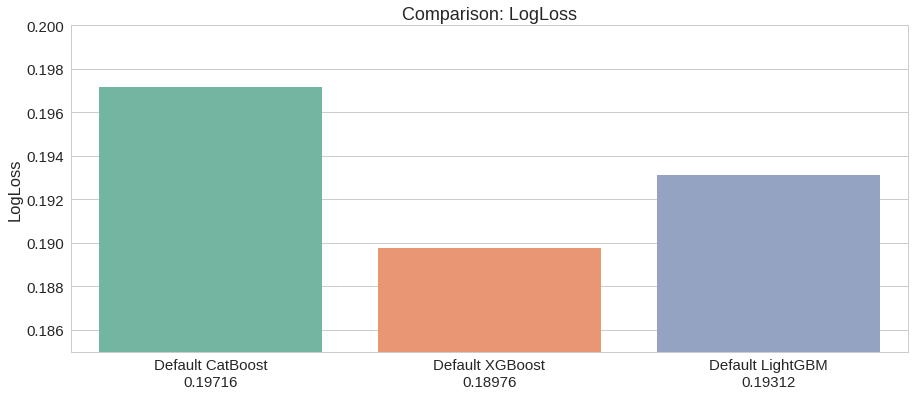

In [46]:
%pylab inline
import seaborn as sns

names = ['%s\n%.5f' % (name, loss) for name, loss in zip(res_df.index, res_df['LogLoss'])]

plt.figure(figsize=(15,6))
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
g = sns.barplot(x=res_df.index, y="LogLoss", data=res_df, palette='Set2')
g.set(ylim=(0.185, 0.2), ylabel='LogLoss', title='Comparison: LogLoss')
_ = g.set_xticklabels(names)

###### F-measure for minority class

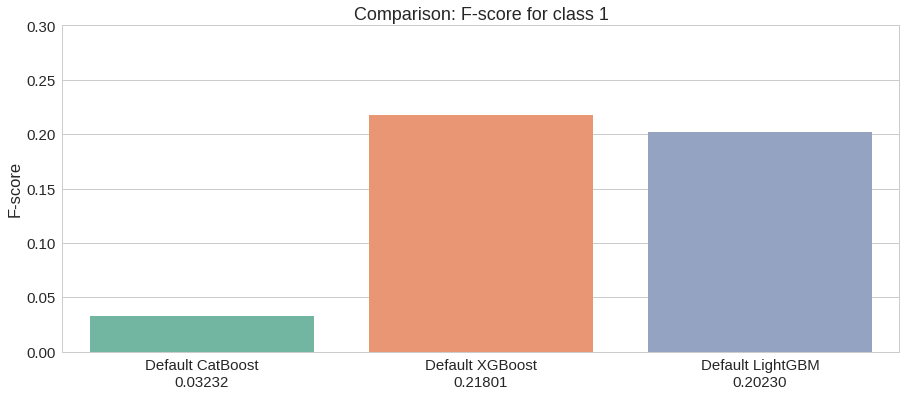

In [47]:
names = ['%s\n%.5f' % (name, loss) for name, loss in zip(res_df.index, res_df['F-measure_Class1'])]

plt.figure(figsize=(15,6))
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
g = sns.barplot(x=res_df.index, y="F-measure_Class1", data=res_df, palette='Set2')
g.set(ylim=(0., 0.3), ylabel='F-score', title='Comparison: F-score for class 1')
_ = g.set_xticklabels(names)

##### Average runtime on testset

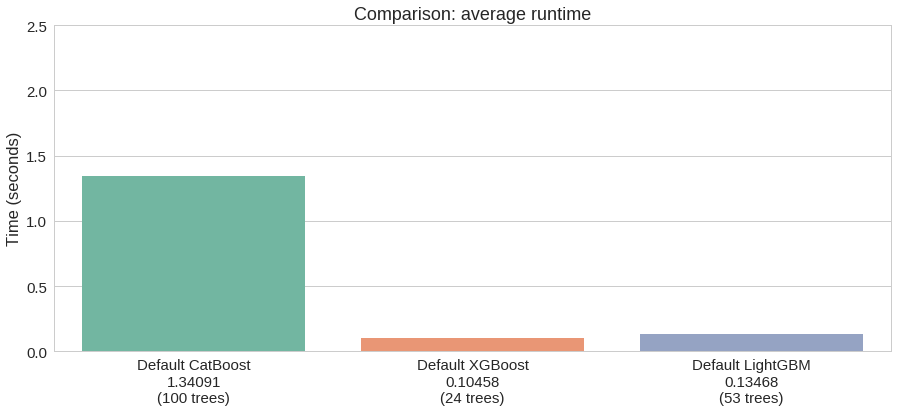

In [48]:
names = ['{}\n{:.5f}\n({} trees)'.format(name, loss, tree) for name, loss, tree in 
         zip(res_df.index, res_df['MeanRuntime'], res_df['NumberOfTrees'])]

plt.figure(figsize=(15,6))
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
g = sns.barplot(x=res_df.index, y="MeanRuntime", data=res_df, palette='Set2')
g.set(ylim=(0., 2.5), ylabel='Time (seconds)', title='Comparison: average runtime')
_ = g.set_xticklabels(names)

In [49]:
print '\n\nIn this task CatBoost is on average\n\n\t\t{:.0f} times slower than XGBoost \n\t\t{:.0f} times slower than LightGBM'.format(
    res_df['MeanRuntime'][0]/res_df['MeanRuntime'][1],
    res_df['MeanRuntime'][0]/res_df['MeanRuntime'][2]
)



In this task CatBoost is on average

		13 times slower than XGBoost 
		10 times slower than LightGBM


Почему я пишу то по-русски, то по-английски? Не знаю.

Теперь 5000.

# n_estimators = 5000

## XGBoost

In [50]:
%%time
xgb_result_moretrees = run_default(XGBExperiment, "XGBoost", n_estimators=5000)

Default XGBoost result on cv:

logloss = 0.1842312
best_n_estimators = 24
params = {'colsample_bytree': 1.0, 'silent': 1, 'eval_metric': 'logloss', 'colsample_bylevel': 1.0, 'min_child_weight': 1, 'subsample': 1.0, 'eta': 0.3, 'objective': 'binary:logistic', 'alpha': 0, 'seed': 0, 'max_depth': 6, 'gamma': 0, 'lambda': 1}

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

For seed=0 Test's logloss : 0.18976
For seed=1 Test's logloss : 0.18976
For seed=2 Test's logloss : 0.18976
For seed=3 Test's logloss : 0.18976
For seed=4 Test's logloss : 0.18976

             precision    recall  f1-score   support

          0       0.94      0.99      0.97      4996
          1       0.64      0.13      0.22       350

avg / total       0.92      0.94      0.92      5346



Test's logloss mean: 0.18976, Test's logloss std: 0.00000

Mean f-score for class 0: 0.96787
Mean f-score for class 1: 0.21801

Mean average f-score: 0.91877


Durations:
[0.10034894943237305, 0.1247091293334961, 0.166142940

# LightGBM

In [51]:
%%time
lgb_result_moretrees = run_default(LGBExperiment, "LightGBM", n_estimators=5000)

Default LightGBM result on cv:

logloss = 0.185523602459
best_n_estimators = 53
params = {'num_leaves': 127, 'verbose': -1, 'bagging_seed': 3, 'learning_rate': 0.1, 'data_random_seed': 1, 'min_data_in_leaf': 100, 'bagging_fraction': 1.0, 'metric': 'binary_logloss', 'feature_fraction_seed': 2, 'lambda_l1': 0, 'bagging_freq': 1, 'lambda_l2': 0, 'max_bin': 255, 'objective': 'binary', 'drop_seed': 4, 'min_sum_hessian_in_leaf': 10, 'feature_fraction': 1.0}

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

For seed=0 Test's logloss : 0.19312
For seed=1 Test's logloss : 0.19312
For seed=2 Test's logloss : 0.19312
For seed=3 Test's logloss : 0.19312
For seed=4 Test's logloss : 0.19312

             precision    recall  f1-score   support

          0       0.94      0.99      0.97      4996
          1       0.52      0.13      0.20       350

avg / total       0.91      0.94      0.92      5346



Test's logloss mean: 0.19312, Test's logloss std: 0.00000

Mean f-score for class 0: 0.9661

# CatBoost

In [53]:
%%time
cab_result_moretrees = run_default(CABExperiment, "CatBoost", n_estimators=5000)

Default CatBoost result on cv:

logloss = 0.18004046564
best_n_estimators = 1101
params = {'rsm': 1.0, 'random_seed': 0, 'verbose': False, 'learning_rate': 0.03, 'ctr_border_count': 16, 'ctr_description': ['Borders', 'Counter'], 'depth': 6, 'fold_len_multiplier': 2, 'loss_function': 'Logloss', 'iterations': 5000, 'l2_leaf_reg': 3, 'leaf_estimation_method': 'Newton', 'gradient_iterations': 10, 'border_count': 128, 'used_ram_limit': 100000000000}

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

For seed=0 Test's logloss : 0.18807
For seed=1 Test's logloss : 0.18738
For seed=2 Test's logloss : 0.18693
For seed=3 Test's logloss : 0.18783
For seed=4 Test's logloss : 0.18743

             precision    recall  f1-score   support

          0       0.94      0.99      0.97      4996
          1       0.58      0.14      0.22       350

avg / total       0.92      0.94      0.92      5346



Test's logloss mean: 0.18753, Test's logloss std: 0.00039

Mean f-score for class 0: 0.96709
Mean 

In [54]:
results_moretrees = [
    cab_result_moretrees,
    xgb_result_moretrees,
    lgb_result_moretrees
]
more_df = pd.DataFrame(np.array(results_moretrees), 
                      columns=['LogLoss', 'F-measure_Class0', 'F-measure_Class1', 'F-measure', 'MeanRuntime', 'NumberOfTrees'], 
            index = ['Default CatBoost', 'Default XGBoost', 'Default LightGBM'],
                     )
more_df['NumberOfTrees'] = more_df['NumberOfTrees'].astype(int)
more_df.round(5)

,LogLoss,F-measure_Class0,F-measure_Class1,F-measure,MeanRuntime,NumberOfTrees
Default CatBoost,0.18753,0.96709,0.20881,0.91745,15.21322,1101
Default XGBoost,0.18976,0.96787,0.21801,0.91877,0.17877,24
Default LightGBM,0.19312,0.96617,0.20230,0.91616,0.16937,53


In [55]:
more_df.to_csv('../results/results_animals_binary_moretrees.csv')

In [3]:
more_df = pd.read_csv('../results/results_animals_binary_moretrees.csv', index_col=0)
more_df.round(5)

,LogLoss,F-measure_Class0,F-measure_Class1,F-measure,MeanRuntime,NumberOfTrees
Default CatBoost,0.18753,0.96709,0.20881,0.91745,15.21322,1101
Default XGBoost,0.18976,0.96787,0.21801,0.91877,0.17877,24
Default LightGBM,0.19312,0.96617,0.20230,0.91616,0.16937,53


###### LogLoss

Populating the interactive namespace from numpy and matplotlib


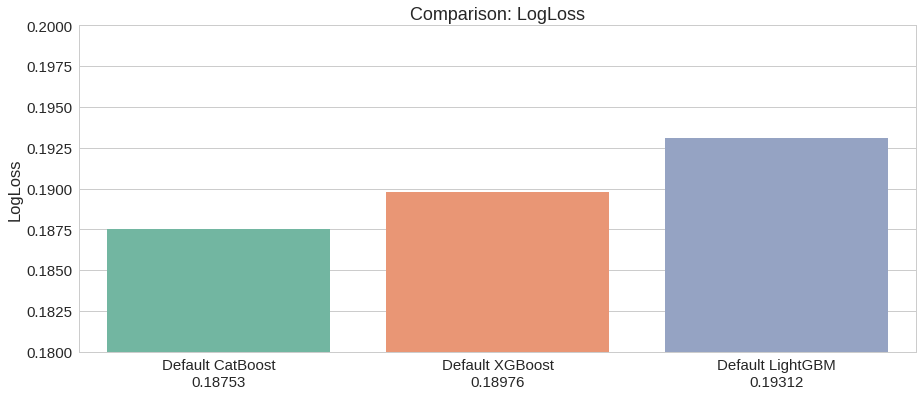

In [4]:
names = ['%s\n%.5f' % (name, loss) for name, loss in zip(more_df.index, more_df['LogLoss'])]

plt.figure(figsize=(15,6))
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
g = sns.barplot(x=more_df.index, y="LogLoss", data=more_df, palette='Set2')
g.set(ylim=(0.18, 0.2), ylabel='LogLoss', title='Comparison: LogLoss')
_ = g.set_xticklabels(names)

###### F-measure for minority class

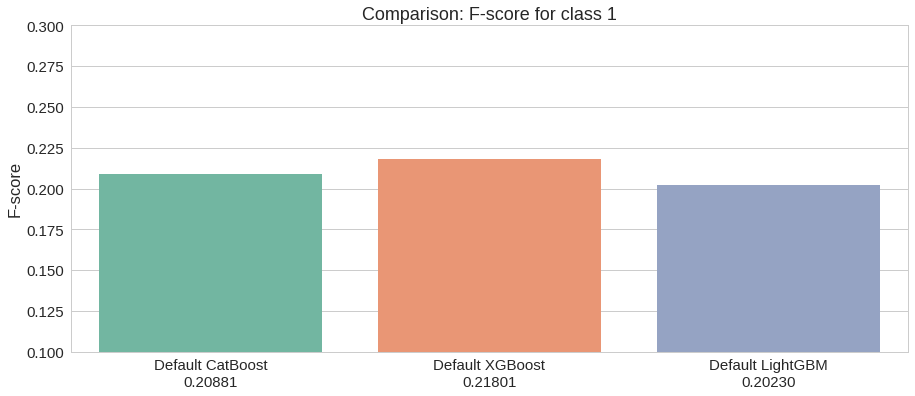

In [5]:
names = ['%s\n%.5f' % (name, loss) for name, loss in zip(more_df.index, more_df['F-measure_Class1'])]

plt.figure(figsize=(15,6))
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
g = sns.barplot(x=more_df.index, y="F-measure_Class1", data=more_df, palette='Set2')
g.set(ylim=(0.1, 0.3), ylabel='F-score', title='Comparison: F-score for class 1')
_ = g.set_xticklabels(names)

##### Average runtime

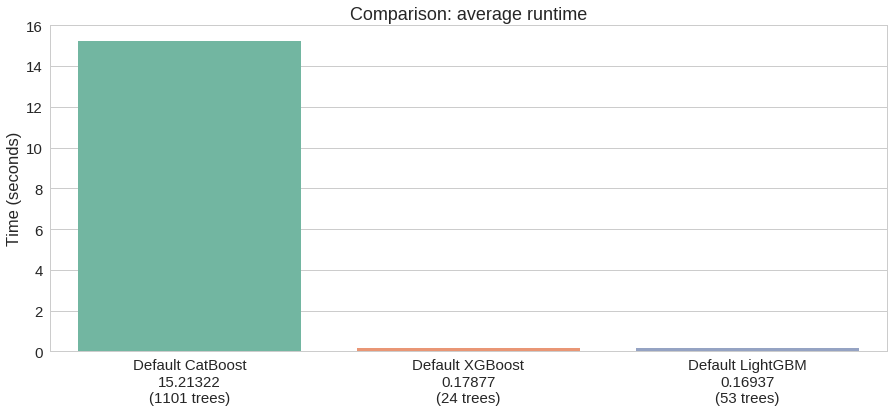

In [12]:
names = ['{}\n{:.5f}\n({} trees)'.format(name, loss, tree) for name, loss, tree in 
         zip(more_df.index, more_df['MeanRuntime'], more_df['NumberOfTrees'])]

plt.figure(figsize=(15,6))
sns.set(font_scale=1.5)
sns.set_style("whitegrid")
g = sns.barplot(x=more_df.index, y="MeanRuntime", data=more_df, palette='Set2')
g.set(ylim=(0., 16), ylabel='Time (seconds)', title='Comparison: average runtime')
_ = g.set_xticklabels(names)